In [1]:
import os, sys
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

sys.path.append('../src')
import scp_infer
import matplotlib.pyplot as plt
%matplotlib inline

/home/jansp/miniconda3/envs/pytorch-jax-310/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
`ModuleAvailableCache` is a special case of `RequirementCache`. Please use `RequirementCache(module=...)` instead.
pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
Deprecated cal

In [2]:
from scp_infer.thirdparty.arboreto_local.algo import grnboost2

### Running GRN Inference on synthetically generated Data

We provide an example synthetic dataset here, in the form of an annotated ``.h5ad`` file, but others can be generated using the ``sergio-knockdown-run.ipynb`` python Notebook.

#### a. Import synthetic data

In [4]:
data_folder = './data/synthetic'
output_folder = './data/synthetic/output'
filename_expression = 'sim_output_q_0.6_d_10_edgeden_0.5_kd_0.0_nsamp_200_noise_n_0.h5ad'
filename_GRN = 'graph_q_0.6_d_10_edgeden_0.5_kd_0.0_nsamp_200_noise_n_0.csv'

adata = sc.read_h5ad(os.path.join(data_folder, filename_expression))
scp_infer.adata.convert_perturb_labels_to_onehot(adata)
GT_adjacency = np.loadtxt(os.path.join(data_folder, filename_GRN), delimiter=',')

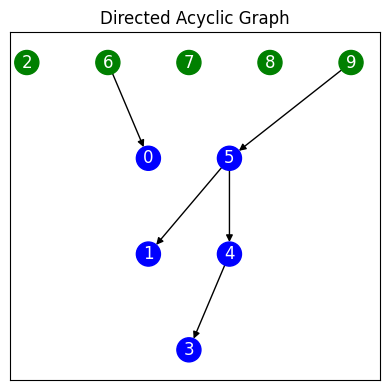

In [5]:
# Visualizing the GRN
graph = nx.from_numpy_array(GT_adjacency, create_using=nx.DiGraph)
scp_infer.utils.plot.plot_matrix.plot_dag(graph, figsize=(4, 4))

#### b. Performing the GRN Inference

In [6]:
implementation_dict = {
    'GRNBoost2': scp_infer.inference.grnboost2.GRNBoost2Imp,
    'GIES': scp_infer.inference.gies.GIESImp,
    'DCDI': scp_infer.inference.dcdi.DCDIImp,
    'Bicycle': scp_infer.inference.bicycle.BicycleImp,
    'AVICI': scp_infer.inference.avici.AVICI_Imp
}

In [7]:
for algorithm in ['GRNBoost2', 'GIES', 'AVICI']:
    out_dir = os.path.join(output_folder, algorithm)
    os.makedirs(out_dir, exist_ok=True)
    # run the inference
    imp_instance = implementation_dict[algorithm](adata[::10], output_dir=out_dir, verbose=True)
    imp_instance.convert_data()
    ad_matrix,runtime = imp_instance.infer(plot=False)
    # apply a threshold to the inferred adjacency matrix (change the threshold selection, include in wrapper?)
    if algorithm == 'GRNBoost2':
        ad_matrix = (ad_matrix > ad_matrix.max()*0.5).astype(int)
    # save the inferred adjacency matrix
    np.savetxt(os.path.join(out_dir, algorithm+'_adjacency_matrix.txt'), ad_matrix)

Running GRNBoost2
preparing dask client
parsing input
creating dask graph
4 partitions
computing dask graph


/home/jansp/miniconda3/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
/home/jansp/miniconda3/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
/home/jansp/miniconda3/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
/home/jansp/miniconda3/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal 

shutting down client and local cluster
finished
GRNBoost2 fnished
Time taken:  9.493478298187256
network shape:  (90, 3)
Saving output
Output saved
Running GIES
GIES fnished
Time taken:  0.35111474990844727
estimate shape:  (10, 10)
Saving output
Output saved
Using default cache_path: `/home/jansp/Documents/Masterarbeit/code/inference-pkg/tutorials/cache`
AVICI data conversion done
Running AVICI
AVICI fnished
Time taken:  4.74816370010376
Memory usage:  23376114
Saving output
Output saved


**DCDI**: For DCDI a few choices regarding model configuration as well as hyerparameter choice have to be made. Here we offer some "toy" parameters to verify that the model runs, for ideal performance these should be adjust adjusted - especially the train iterations should be increased and the learning rate decreased.

Parameters which we have found to work well are:

    - train_iterations = 150000
    - learning_rate = 1e-2
    - reg_coeff = 1e-1

The model train and test likelihoods, as well as it's learned edge weights can be observed during training in `learning-curves.png` and `w_adj_gumbel.png` respectively.

In [7]:
algorithm = 'DCDI'
out_dir = os.path.join(output_folder, algorithm)
if not os.path.exists(out_dir): 
    os.makedirs(out_dir)
imp_instance = scp_infer.inference.DCDIImp(
    adata[::10], 
    output_dir=out_dir, 
    verbose=True,
    train_iterations = 5000,
    learning_rate = 1e-1,
    reg_coeff = 1e-1,
    use_GPU=False,
    weighted_adjacency=True,
)

imp_instance.convert_data()
ad_matrix, runtime = imp_instance.infer(print_metrics = False)
print(f"Inferred GRN for {algorithm} with {np.sum(ad_matrix > 0.5)} edges.")
np.savetxt(os.path.join(out_dir, algorithm+'_weighted_adjacency_matrix.txt'), ad_matrix)
np.savetxt(os.path.join(out_dir, algorithm+'_adjacency_matrix.txt'), (ad_matrix > 0.5).astype(int))

num_regimes: 11
train_data.adjacency.device: cpu
Running DCDI


/home/jansp/Documents/Masterarbeit/code/inference-pkg/tutorials/../src/scp_infer/thirdparty/dcdi_local/prox.py:43: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)


Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000
Iteration: 1100
Iteration: 1200
Iteration: 1300
Iteration: 1400
Iteration: 1500
Iteration: 1600
Iteration: 1700
Iteration: 1800
Iteration: 1900
Iteration: 2000
Iteration: 2100
Iteration: 2200
Iteration: 2300
Iteration: 2400
Iteration: 2500
Iteration: 2600
Iteration: 2700
Iteration: 2800
Iteration: 2900
Iteration: 3000
Iteration: 3100
Iteration: 3200
Iteration: 3300
Iteration: 3400
Iteration: 3500
Iteration: 3600
Iteration: 3700
Iteration: 3800
Updated gamma to 3.5791201989007932e-12
Iteration: 3900
Iteration: 4000
Iteration: 4100
Iteration: 4200
Iteration: 4300
Iteration: 4400
Iteration: 4500
Iteration: 4600
Iteration: 4700
Iteration: 4800
Iteration: 4900
DCDI finished
Time taken:  508.73583030700684
Memory usage:  0
Saving output
Output saved
Inferred GRN for DCDI with 8 edges.


__Bicycle__: Bicycle is designed for discrete "count" gene expression data, which is confounded with technical noise - therefore it is only of interest to apply it to synthetic data with such technical noise (not here).

In [ ]:
algorithm = 'Bicycle'
out_dir = os.path.join(output_folder, algorithm)
os.makedirs(out_dir, exist_ok=True)
adata_raw = adata.copy()
adata_raw.X = adata_raw.layers["counts"].copy()  # Use raw counts for Bicycle
imp_instance = scp_infer.inference.bicycle.BicycleImp(
    adata_raw[::10], 
    output_dir=out_dir, 
    verbose=True,
    n_epochs = 10000,
    n_epochs_pretrain_latents = 5000,
    scale_lyapunov = 0.1)
imp_instance.convert_data()
ad_matrix, runtime = imp_instance.infer(plot=True)
print(f"Inferred GRN for {algorithm} with {np.sum(ad_matrix > 0.5)} edges.")

#### c. Visualizing results

Inferred GRN for GRNBoost2 with shape (10, 10), min 0.0, max 1.0
Inferred GRN for GIES with shape (10, 10), min 0.0, max 1.0
Inferred GRN for DCDI with shape (10, 10), min 0.0, max 1.0
Inferred GRN for AVICI with shape (10, 10), min 0.0, max 1.0


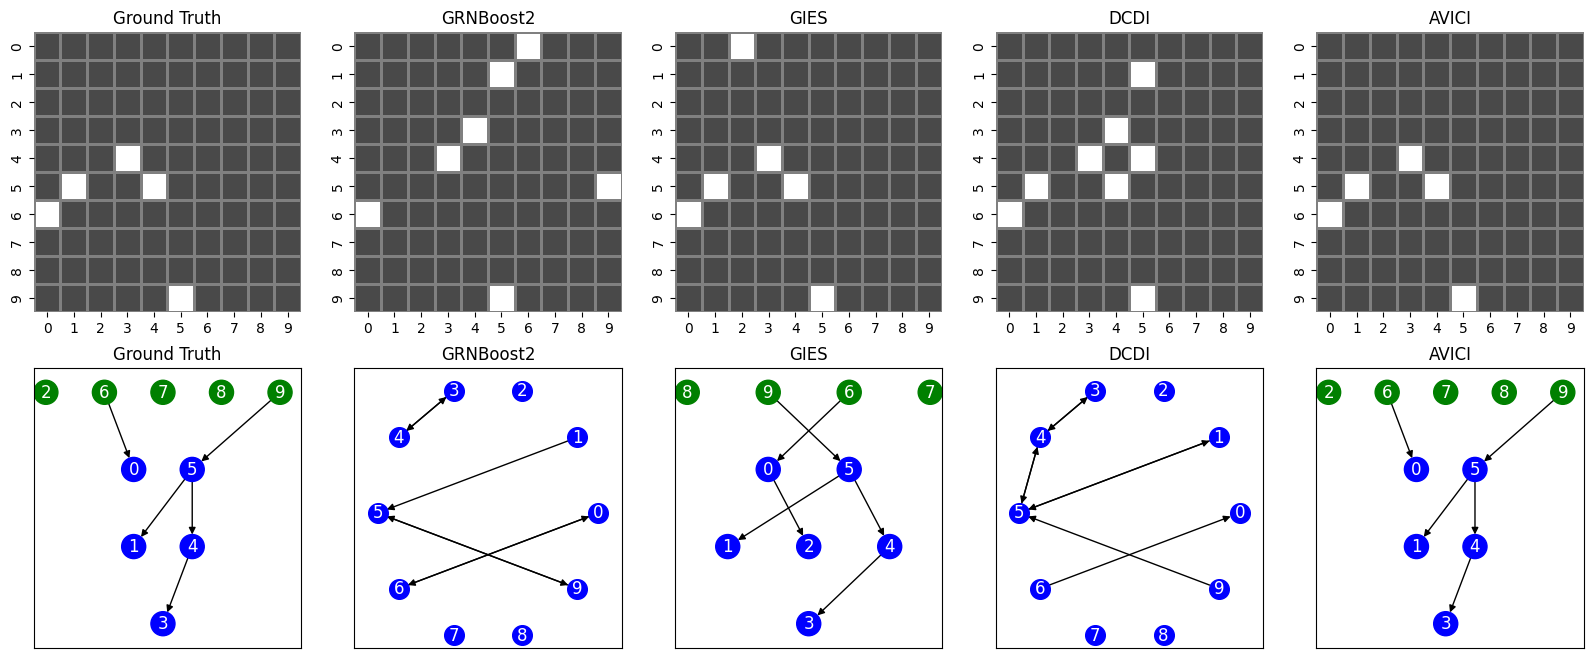

In [8]:
algorithms = ['GRNBoost2', 'GIES', 'DCDI', 'AVICI']

fig, axes = plt.subplots(2,len(algorithms)+1, figsize=((4 * (len(algorithms)+1)), 8))

# plot the ground truth GRN
axes[0,0].set_title('Ground Truth')
sns.heatmap(GT_adjacency, ax=axes[0,0], cbar=False, linewidths = 2, linecolor = 'gray', cmap='gray',vmin=-0.4,vmax=1)
scp_infer.utils.plot.plot_matrix.plot_dag(nx.from_numpy_array(GT_adjacency, create_using=nx.DiGraph), figsize=(4, 4), title='Ground Truth', axis=axes[1,0])

# plot the inferred GRN graphs
for i, algorithm in enumerate(algorithms):
    out_dir = os.path.join(output_folder, algorithm)
    GRN = np.loadtxt(os.path.join(out_dir, algorithm+'_adjacency_matrix.txt'))
    print(f"Inferred GRN for {algorithm} with shape {GRN.shape}, min {GRN.min()}, max {GRN.max()}")
    graph = nx.from_numpy_array(GRN, create_using=nx.DiGraph)
    axes[0,i+1].set_title(algorithm)
    #axes[0,i].imshow(GRN, cmap='Blues', vmin=0, vmax=1)
    sns.heatmap(GRN, ax=axes[0,i+1], cbar=False, linewidths = 2, linecolor = 'gray', cmap='gray',vmin=-0.4,vmax=1)
    try:
        scp_infer.utils.plot.plot_matrix.plot_dag(graph, figsize=(4, 4), title=algorithm, axis=axes[1,i+1])
    except:
        nx.draw_networkx(graph, pos=nx.circular_layout(graph), ax=axes[1,i+1], with_labels=True, node_size=200, font_size=12, node_color='blue', font_color='white')
        axes[1,i+1].set_title(algorithm)

Inferred GRN for GRNBoost2 with 7 edges.
F-beta score for GRNBoost2: 0.45454545454545453
Inferred GRN for GIES with 6 edges.
F-beta score for GIES: 0.8620689655172415
Inferred GRN for DCDI with 8 edges.
F-beta score for DCDI: 0.6756756756756757
Inferred GRN for AVICI with 5 edges.
F-beta score for AVICI: 1.0


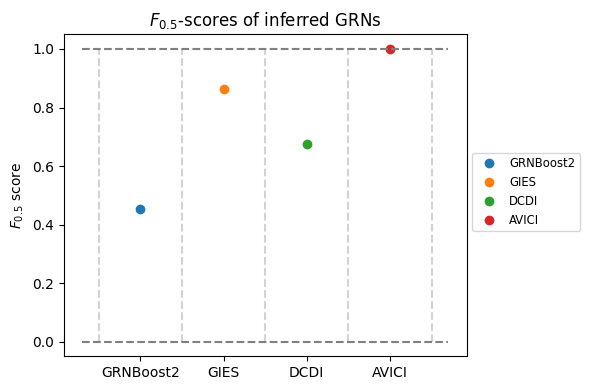

In [9]:
# comparing inferred GRNs with the ground truth
fig, ax = plt.subplots(figsize=(6,4))

for i,algorithm in enumerate(algorithms):
    out_dir = os.path.join(output_folder, algorithm)
    GRN = np.loadtxt(os.path.join(out_dir, algorithm+'_adjacency_matrix.txt'))
    print(f"Inferred GRN for {algorithm} with {np.sum(GRN > 0)} edges.")
    beta=0.5
    f_beta = scp_infer.eval.sim_eval.f_score(GT_adjacency, GRN, beta=beta)
    print(f"F-beta score for {algorithm}: {f_beta}")
    ax.plot(i, f_beta, 'o', label=algorithm)
plt.vlines(np.arange(len(algorithms)+1)-0.5, 0,1, color='lightgray', linestyle='--')
plt.hlines((0,1), *ax.get_xlim(), color='gray', linestyle='--')
ax.set_xticks(range(len(algorithms)))
ax.set_xticklabels(algorithms)
ax.set_ylabel(r'$F_{0.5}$ score')
ax.set_title(r'$F_{0.5}$-scores of inferred GRNs')
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.65), fontsize='small')
plt.tight_layout()
plt.show()